# Imbalanced dataset

Handling imbalanced datasets is a common challenge in machine learning, particularly in classification tasks where the distribution of classes is uneven. Here are several strategies to address imbalanced datasets:

1. **Data-level approaches:**
    - **Resampling:**
        - **Undersampling:** Reduce the number of instances of the over-represented class. This can be done randomly or in a more strategic way to preserve important patterns.
        - **Oversampling:** Increase the number of instances of the under-represented class. This can be achieved by replicating instances or generating synthetic examples using techniques like SMOTE (Synthetic Minority Over-sampling Technique).
    - **Data Augmentation:**
      - Augment the minority class data by introducing variations or transformations to existing instances.
2. **Algorithm-level approaches:**
  - **Ensemble Methods:**
    - Use ensemble methods like Random Forests or Gradient Boosting (xgboost), which can handle imbalanced datasets better than some other algorithms.
    - Train different models on subsets of the data and combine their predictions. This can help capture diverse patterns present in the imbalanced dataset.
  - **Reformulate the problem:**
    - Frame a multiclass classification as a **One versus the Rest (OVR)** classification, i.e., a binary classification per class. In other terms, if the number of classes are 10, instead of creating one model that classifies the 10 classes, you will create 10 binary classifiers, each predicting the probability of one class.
    - Frame the problem as an **anomaly detection** task, treating the minority class as the rare event to be detected.

3. **Choice of Evaluation Metrics:**
   - Accuracy, consider using evaluation metrics that are more informative for imbalanced datasets, such as confusion matrix, precision, recall, F1 score, area under the Receiver Operating Characteristic (ROC) curve (AUC-ROC), area under the Precision-Recall curve (AUC-PR), or Matthews Correlation Coefficient (MCC).

4. **Cost-sensitive Learning:**
  - **Weighting Data Space:**
    - Assign different misclassification costs to different classes. Some algorithms allow you to assign weights to classes to make them more or less important during training. Use, for example, the hyperparameter `class_weight="balances"` in the ML models like `LogisticRegression`, `DecisionTreeClassifier`, etc., or do this manually.
  - **Adapting Learning algorithms:**
    - Design custom loss functions that penalize misclassifying the minority class more heavily.

5. **Transfer Learning:**
    - Leverage knowledge from a model trained on a related task or a dataset with a balanced class distribution.

The best choice does not exist, it will always depend on the situation: the dataset and the problem you're trying to solve.

You should always explore multiple approaches to find the one that works best for your case.

# References
1. [Classification of imbalanced data: a review](https://www.researchgate.net/profile/Andrew-Wong-43/publication/263913891_Classification_of_imbalanced_data_a_review/links/550e28780cf212874167e2af/Classification-of-imbalanced-data-a-review.pdf)

<h1 align="center"> Credit Fraud Detector </h1>

<h2>Tips for Imbalanced Datasets: </h2>
<ul>
<li> Never test on the oversampled or undersampled dataset.</li>
<li>If we want to implement cross validation, remember to oversample or undersample your training data <b>during</b> cross-validation, not before! </li>
<li> Don't use <b>accuracy score </b> as a metric with imbalanced datasets (will be usually high and misleading), instead use <b>f1-score, precision/recall score or confusion matrix </b></li>
</ul>


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import classification_report, recall_score
import warnings
warnings.filterwarnings("ignore")

## Gather Sense of Our Data:
<a id="gather"></a>
The first thing we must do is gather a <b> basic sense </b> of our data. Remember, except for the <b>transaction</b> and <b>amount</b> we dont know what the other columns are (due to privacy reasons). The only thing we know, is that those columns that are unknown have been scaled already.   

<h3> Summary: </h3>
<ul>
<li>The transaction amount is relatively <b>small</b>. The mean of all the mounts made is approximately USD 88. </li>
<li>There are no <b>"Null"</b> values, so we don't have to work on ways to replace values. </li>
<li> Most of the transactions were <b>Non-Fraud</b> (99.83%) of the time, while <b>Fraud</b> transactions occurs (017%) of the time in the dataframe. </li>
</ul>

<h3> Feature Technicalities: </h3>
<ul>
<li> <b>PCA Transformation: </b>  The description of the data says that all the features went through a PCA transformation (Dimensionality Reduction technique) (Except for time and amount).</li>
<li> <b>Scaling:</b> Keep in mind that in order to implement a PCA transformation features need to be previously scaled. (In this case, all the V features have been scaled or at least that is what we are assuming the people that develop the dataset did.)</li>
</ul>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/Advanced\ Machine\ Learning\ Course

/content/drive/MyDrive/Advanced Machine Learning Course


In [4]:
df = pd.read_csv('./creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
len(df)

284807

In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
# Good No Null Values!
df.isnull().sum().max()

0

In [ ]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [ ]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


**Note:**  Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

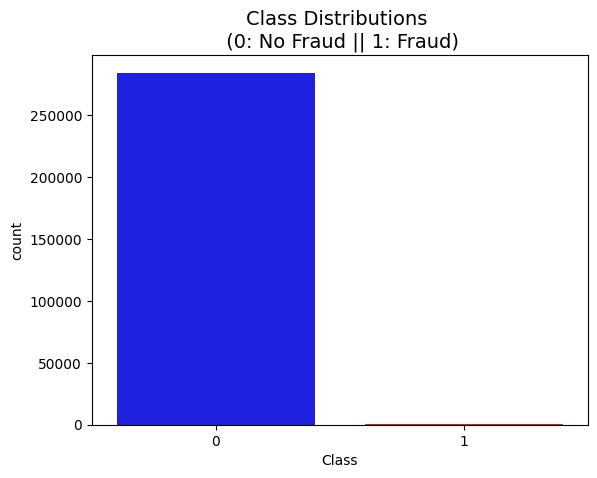

In [ ]:
colors = ["blue", "red"]

sns.countplot(data=df, x='Class', palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

In [5]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [6]:
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)

In [7]:
X_train.shape, len(y_train), X_test.shape, len(y_test)

((227845, 30), 227845, (56962, 30), 56962)

# Let us train a ML model to predict if a transaction is fraudulent or not.

Since we do have an imbalanced dataset, we will use a performance metric that is more convenient with imbalance, i.e., not accuracy!

The goal here is to predict when the transaction is fraudulent. <br>
Moreover, it is not acceptable to let any fraudulent transaction slide -->it is ok to predict a non-fraudulent transaction as fraudulent but not vice-versa --> here it is the recall that matters not the precision.

In [ ]:
model = LogisticRegression(random_state=7)
params = {
    'penalty':['l1', 'l2'],
    'C': np.arange(1,100)
}
search = RandomizedSearchCV(model, scoring='recall', cv=10,
                            n_iter=10, param_distributions=params,
                            refit=True, n_jobs=-1)
search.fit(X_train, y_train)
best_model = search.best_estimator_

In [ ]:
best_model

LogisticRegression(C=23, random_state=7)

In [ ]:
results = pd.DataFrame(data=search.cv_results_)
results.sort_values(by='rank_test_score')
# Rank 1 model has l2 penalty and C=23

In [ ]:
print('Performance on the train set')
y_pred_train = best_model.predict(X_train)
print('Train recall:', recall_score(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

Performance on the train set
Train recall: 0.6015228426395939
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.88      0.60      0.71       394

    accuracy                           1.00    227845
   macro avg       0.94      0.80      0.86    227845
weighted avg       1.00      1.00      1.00    227845



In [ ]:
print('Performance on the test set')
y_pred = best_model.predict(X_test)
print('Test recall:', recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Performance on the test set
Test recall: 0.6530612244897959
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.65      0.74        98

    accuracy                           1.00     56962
   macro avg       0.93      0.83      0.87     56962
weighted avg       1.00      1.00      1.00     56962



## Analysis
From above, we see that our model is 100% accurate when it comes to classifying non-fraudulent transactions.

However, it is very bad on predicting fraudulent transactions (65% of recall), which is its main goal!!!


As a matter of fact, the presence of imbalance makes the fitted ML models prone to:
- **Overfitting:** Our classification models will be biased towards the no fraud class (the majority class)! What we want for our model is to be certain when a fraud occurs.
- **Wrong Correlations:** Although we don't know what the "V" features stand for, it will be useful to understand how each of this features influence the target (Fraud or No Fraud) by having an imbalance dataframe we are not able to see the true correlations between the class and features.

## Cost-sensitive Learning

Let us use this approach, we will weight the data samples differently.

Data samples belonging to the minority class will get more weight than the one from the majority class.

Thankfully, we do not have to hard code this. This is already implemented implicitly in sklearn for `LogisticRegression`; we simply need to put the hyperparameter `class_weight='balanced'`

In [ ]:
model = LogisticRegression(class_weight='balanced', random_state=7)
params = {
    'penalty':['l1', 'l2'],
    'C': np.arange(1,100)
}
search = RandomizedSearchCV(model, scoring='recall', cv=10,
                            n_iter=10, param_distributions=params,
                            refit=True, n_jobs=-1)
search.fit(X_train, y_train)
best_model = search.best_estimator_

In [ ]:
best_model

LogisticRegression(C=2, class_weight='balanced', random_state=7)

In [ ]:
results = pd.DataFrame(data=search.cv_results_)
results.sort_values(by='rank_test_score')
# Rank 1 model has l2 penalty and C=33

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,8.150305,3.301790,0.058095,0.047283,l2,2,"{'penalty': 'l2', 'C': 2}",0.948718,0.95,0.95,0.875,0.975,0.897436,0.923077,0.820513,0.897436,0.871795,0.910897,0.044828,1
1,7.863023,1.469875,0.046896,0.028766,l2,8,"{'penalty': 'l2', 'C': 8}",0.948718,0.95,0.95,0.875,0.975,0.897436,0.923077,0.820513,0.897436,0.871795,0.910897,0.044828,1
4,5.304589,1.640056,0.020353,0.006368,l2,99,"{'penalty': 'l2', 'C': 99}",0.948718,0.95,0.95,0.875,0.975,0.897436,0.923077,0.820513,0.897436,0.871795,0.910897,0.044828,1
5,4.417870,0.692116,0.021713,0.007426,l2,98,"{'penalty': 'l2', 'C': 98}",0.948718,0.95,0.95,0.875,0.975,0.897436,0.923077,0.820513,0.897436,0.871795,0.910897,0.044828,1
9,4.359696,0.839819,0.020670,0.008574,l2,95,"{'penalty': 'l2', 'C': 95}",0.948718,0.95,0.95,0.875,0.975,0.897436,0.923077,0.820513,0.897436,0.871795,0.910897,0.044828,1
2,0.087267,0.031555,0.000000,0.000000,l1,21,"{'penalty': 'l1', 'C': 21}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
3,0.155308,0.025968,0.000000,0.000000,l1,85,"{'penalty': 'l1', 'C': 85}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
6,0.049858,0.005268,0.000000,0.000000,l1,16,"{'penalty': 'l1', 'C': 16}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
7,0.047348,0.002498,0.000000,0.000000,l1,67,"{'penalty': 'l1', 'C': 67}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
8,0.045940,0.002438,0.000000,0.000000,l1,41,"{'penalty': 'l1', 'C': 41}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6


In [ ]:
print('Performance on the train set')
y_pred_train = best_model.predict(X_train)
print('Train recall:', recall_score(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

Performance on the train set
Train recall: 0.9187817258883249
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    227451
           1       0.06      0.92      0.12       394

    accuracy                           0.98    227845
   macro avg       0.53      0.95      0.55    227845
weighted avg       1.00      0.98      0.99    227845



In [ ]:
print('Performance on the test set')
y_pred = best_model.predict(X_test)
print('Test recall:', recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Performance on the test set
Test recall: 0.9285714285714286
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.93      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962



As you can see, we already started seeing an improvement.

The test recall on the class 1 (fraud) increased from 65% to 93%.

However, the precision decreased drastically to 6%!!!

While it is true that we prefer recall over precision, but we also do not want to fall in a situation where we will consider any transaction fraudulent just to be on the safe side!!! the clients would be very furious!!!

Thus, we will switch to the algorithm-level approach and replace logistic regression by an ensemble method like RandomForest or GradientBoosting; they are better at handling imbalance due to the sample and feature bootstrap technique; i.e., subsampling the training data to several training data subsets with replacement and training each tree of the forest on this new data subset while also subsetting the features.

## Algorithm-level approach

In [ ]:
!pip install lightgbm

In [ ]:
model = LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
                       n_estimators = 300,
                       colsample_bytree = .7,
                       min_child_samples=10,
                       subsample=.7,
                       objective='binary',
                       random_state=7, n_jobs=-1,
                       importance_type='split')
# params = {
#     'n_estimators':[100, 300, 500],
    # 'colsample_bytree': [1., int(np.sqrt(X_train.shape[1]))/X_train.shape[1], .7 ],
    # 'min_child_samples': [10, 50],
    # 'subsample': [.7, 1.]
# }
# search = RandomizedSearchCV(model, scoring='recall', cv=3,
#                             n_iter=10, param_distributions=params,
#                             refit=True, n_jobs=-1)
%timeit model.fit(X_train, y_train)
best_model = model #search.best_estimator_

[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.213428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info

In [ ]:
# results = pd.DataFrame(data=search.cv_results_)
# results.sort_values(by='rank_test_score').head()

In [ ]:
print('Performance on the train set')
y_pred_train = best_model.predict(X_train)
print('Train recall:', recall_score(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

Performance on the train set
Train recall: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00       394

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845



In [ ]:
print('Performance on the test set')
y_pred = best_model.predict(X_test)
print('Test recall:', recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Performance on the test set
Test recall: 0.8673469387755102
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.87      0.89        98

    accuracy                           1.00     56962
   macro avg       0.96      0.93      0.95     56962
weighted avg       1.00      1.00      1.00     56962



Now, the recall decresed from 93% to 87%, but the precision increased from 6 to 92%.

Thus, Gradient Boosting is better when it comes to dealing with imbalance. However, here, with the gap between train and test metrics, we believe that we have reached an overfitting.

Thus, it might be better to start thinking a way to balance our data to get something better.

--> We will try now data-level approaches.

## Data-level approaches

### Resampling
Resampling is only applied on the train data, not the test data, nor the validation! <br>
Thus, it is better that you split the train again into train and validation, and then you resample the train set.
#### [Under-Sampling](https://imbalanced-learn.org/stable/under_sampling.html):

"*Under Sampling*" consists of removing data in order to have a more <b> balanced dataset </b> and thus avoiding overfitting.

**Steps:**
- Identify the minority class & its number of instances
- Since here the minority class is the <b>fraud transactions </b> (Fraud = "1") , we should bring the <b>non-fraud transactions</b> to the same amount as fraud transactions (assuming we want a 50/50 ratio), this will be equivalent to 394 cases of fraud and 394 cases of non-fraud transactions.  

**Note:**
- The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of <b>information loss</b> (bringing 394 non-fraud transaction  from 227,451 non-fraud transaction).
- There are other types of undersampling, you can find them [here](https://imbalanced-learn.org/stable/under_sampling.html).

In [ ]:
y_train.value_counts()

0    227451
1       394
Name: Class, dtype: int64

In [ ]:
from imblearn.under_sampling import NearMiss
resampling = NearMiss(version=1)
X_train_resampled, y_train_resampled = resampling.fit_resample(X_train, y_train)

<Axes: xlabel='Class', ylabel='count'>

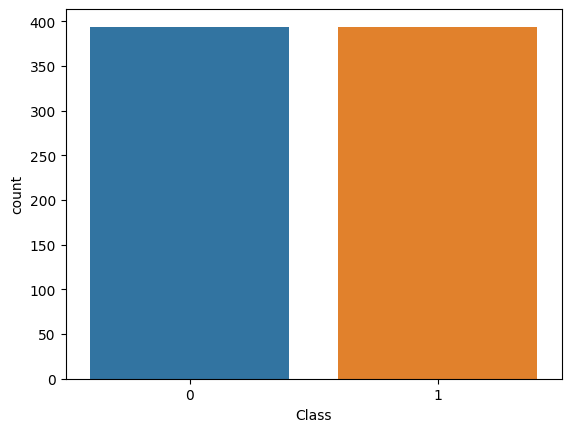

In [ ]:
sns.countplot(x=y_train_resampled)

In [ ]:
model = LGBMClassifier(boosting_type='gbdt',
                      #  class_weight='balanced',
                      #  n_estimators = 50,
                      #  colsample_bytree = .7,
                      #  min_child_samples=10,
                      #  subsample=.7,
                      #  objective='binary',
                       random_state=7, n_jobs=-1,
                       importance_type='split')
params = {
    'n_estimators':[100, 300, 500],
    'colsample_bytree': [1., int(np.sqrt(X_train.shape[1]))/X_train.shape[1], .7 ],
    'min_child_samples': [10, 50],
    'subsample': [.7, 1.]
}
search = RandomizedSearchCV(model, scoring='recall', cv=3, random_state=7,
                            n_iter=1, param_distributions=params,
                            refit=True, n_jobs=-1, verbose=2)
%timeit search.fit(X_train_resampled, y_train_resampled)
best_model = search.best_estimator_

In [ ]:
print('Performance on the train set')
y_pred_train = best_model.predict(X_train_resampled)
print('Train recall:', recall_score(y_train_resampled, y_pred_train))
print(classification_report(y_train_resampled, y_pred_train))

Performance on the train set
Train recall: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       394
           1       1.00      1.00      1.00       394

    accuracy                           1.00       788
   macro avg       1.00      1.00      1.00       788
weighted avg       1.00      1.00      1.00       788



In [ ]:
print('Performance on the train set')
y_pred_train = best_model.predict(X_train)
print('Train recall:', recall_score(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

Performance on the train set
Train recall: 1.0
              precision    recall  f1-score   support

           0       1.00      0.27      0.43    227451
           1       0.00      1.00      0.00       394

    accuracy                           0.27    227845
   macro avg       0.50      0.64      0.22    227845
weighted avg       1.00      0.27      0.43    227845



In [ ]:
print('Performance on the test set')
y_pred = best_model.predict(X_test)
print('Test recall:', recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Performance on the test set
Test recall: 0.9897959183673469
              precision    recall  f1-score   support

           0       1.00      0.27      0.43     56864
           1       0.00      0.99      0.00        98

    accuracy                           0.27     56962
   macro avg       0.50      0.63      0.22     56962
weighted avg       1.00      0.27      0.43     56962



The train preicion & recall on the resampled train dataset shows clear overfitting!!!

We have tested then again all train set, the model performs very bad.

For the test set, the recall increased to 99% but the precision decreased to 0% on the class fraudulent!!! <br>

Thus, this method of resampling made us loose lots of information!!

We will try now oversampling instead.

#### [Over-Sampling](https://imbalanced-learn.org/stable/over_sampling.html):

"*Over Sampling*" consists of adding data in order to have a more <b> balanced dataset </b> and thus avoiding overfitting.

**Steps:**
- Identify the majority class & its number of instances
- Since here the majority class is the <b> non-fraud transactions </b>, we should bring the <b>fraud transactions</b> to the same amount as non-fraud transactions (assuming we want a 50/50 ratio), this will be equivalent to 227451 cases of fraud and 227451 cases of non-fraud transactions.  

In [ ]:
y_train.value_counts()

0    227451
1       394
Name: Class, dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTE
resampling = SMOTE(random_state=7)
X_train_resampled, y_train_resampled = resampling.fit_resample(X_train, y_train)

<Axes: xlabel='Class', ylabel='count'>

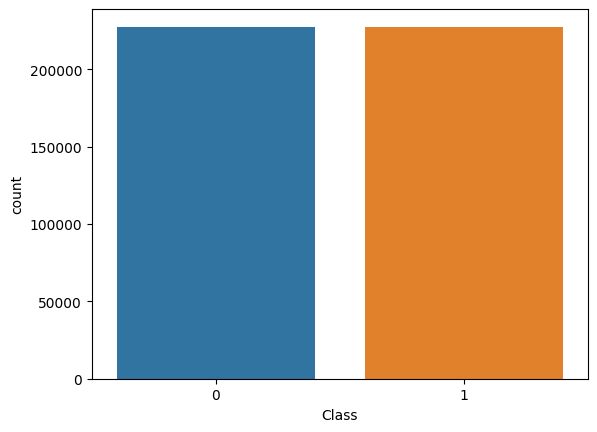

In [ ]:
sns.countplot(x=y_train_resampled)

In [ ]:
model = LGBMClassifier(boosting_type='gbdt',
                      #  class_weight='balanced',
                      #  n_estimators = 50,
                      #  colsample_bytree = .7,
                      #  min_child_samples=10,
                      #  subsample=.7,
                      #  objective='binary',
                       random_state=7, n_jobs=-1,
                       importance_type='split')
%timeit model.fit(X_train_resampled, y_train_resampled)
best_model = model

[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.334689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 454902, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 454902, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise mu

In [ ]:
print('Performance on the train set')
y_pred_train = best_model.predict(X_train_resampled)
print('Train recall:', recall_score(y_train_resampled, y_pred_train))
print(classification_report(y_train_resampled, y_pred_train))

Performance on the train set
Train recall: 0.9999120689730975
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227451

    accuracy                           1.00    454902
   macro avg       1.00      1.00      1.00    454902
weighted avg       1.00      1.00      1.00    454902



In [ ]:
print('Performance on the train set')
y_pred_train = best_model.predict(X_train)
print('Train recall:', recall_score(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

Performance on the train set
Train recall: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.66      1.00      0.79       394

    accuracy                           1.00    227845
   macro avg       0.83      1.00      0.90    227845
weighted avg       1.00      1.00      1.00    227845



In [ ]:
print('Performance on the test set')
y_pred = best_model.predict(X_test)
print('Test recall:', recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Performance on the test set
Test recall: 0.8571428571428571
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.54      0.86      0.66        98

    accuracy                           1.00     56962
   macro avg       0.77      0.93      0.83     56962
weighted avg       1.00      1.00      1.00     56962



Oversampling is definetly better than Undersampling, But overfitting is clear here; the drop in recall between train and test for class=1 is of 14% (100-86%) and the drop in precision for the class=1 is of 12%.

However, it is not better than without any resampling!

Maybe, try undersampling using clustering methods (like the use case of MNIST classification we have seen in the unsupervised learning course).

To sample the most representative data points from the majority class, we will cluster them with k=394 because we need to sample 394 data points since our minority class contains 394 data points.

In [ ]:
X_train_class_majority = X_train[y_train == 0]
X_train_class_majority.shape

(227451, 30)

In [ ]:
y_train.value_counts()

0    227451
1       394
Name: Class, dtype: int64

In [ ]:
X_train_class_majority.reset_index(inplace=True)

In [ ]:
X_train_class_majority = X_train_class_majority.drop(columns=['index'], axis=1)

In [ ]:
from sklearn.cluster import KMeans

k = y_train.value_counts()[1] # 394
# Initialize a Kmeans model with k=50, n_init=10, and a random_state=42
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
# Fit the model to X_train
kmeans.fit(X_train_class_majority)
# Reduce the dimensionality of X_train using kmeans
X_dist = kmeans.transform(X_train_class_majority)
# the shape of X_dist is (n, k), with n = 227451 = total nbr of training samples of the full dataset, k = 394 = nbr of clusters
# For every cluster k, I choose the index of the data point that has the lowest distance to the centroid of this cluster
# This sample is the most representative of the cluster
# I end up with 394 samples (since I have k=394 clusters)
representative_data_point_idx = X_dist.argmin(axis=0)
# shape of representative_data_point_idx = 394
print('The 10 first indices of the most representative images are:', representative_data_point_idx[:10])
# Here we are extracting these representative images from the train set
X_representative_data_points = X_train_class_majority.loc[ representative_data_point_idx.tolist(), :]
# shape of X_representative_digits = (394, 30); 394=nbr of representative images, 30=dimension of each data point i.e., number of columns

In [ ]:
new_X_train = X_train[y_train==1].append(X_representative_data_points)
new_y_train = np.append(np.array(y_train[y_train==1]), np.zeros(X_representative_data_points.shape[0]))
new_X_train['Class'] = new_y_train
# Shuffling the dataset
new_X_train = new_X_train.sample(frac = 1)
model = LGBMClassifier(boosting_type='gbdt',
                      #  class_weight='balanced',
                      #  n_estimators = 50,
                      #  colsample_bytree = .7,
                      #  min_child_samples=10,
                      #  subsample=.7,
                      #  objective='binary',
                       random_state=7, n_jobs=-1,
                       importance_type='split')
%timeit model.fit(new_X_train.drop(columns=['Class']), new_X_train['Class'])
best_model = model

[LightGBM] [Info] Number of positive: 394, number of negative: 394
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 788, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 394, number of negative: 394
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 788, number of used f

In [ ]:
print('Performance on the train set')
y_pred_train = best_model.predict(X_train)
print('Train recall:', recall_score(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

Performance on the train set
Train recall: 1.0
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    227451
           1       0.03      1.00      0.06       394

    accuracy                           0.95    227845
   macro avg       0.52      0.97      0.52    227845
weighted avg       1.00      0.95      0.97    227845



In [ ]:
print('Performance on the test set')
y_pred = best_model.predict(X_test)
print('Test recall:', recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Performance on the test set
Test recall: 0.9387755102040817
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56864
           1       0.03      0.94      0.06        98

    accuracy                           0.95     56962
   macro avg       0.51      0.94      0.52     56962
weighted avg       1.00      0.95      0.97     56962



No overfitting here (the drop in performance in 6% for the recall of class=1), but the performance is still bad, even if the recall is high 94% (recall of class=1 on the test set), the precision test is 3%.

Let us now try to reformulate the problem as an anomaly detection problem.

### Classification problem as an anomaly detection problem

Instead of learning to discriminate between fraudulent and non-fraudulent transactions, we will build a model that only learns on the non-fraudulent transaction.

This model will encode the input columns and then decode them; we are going to call the output the reconstruction of the input.

Since the model is trained on only non-fraudulent data, no matter what input we give, it will try to reconstruct the non-fraudulent version of it.

Thus, the mean squarred error between the input and output will be low if the input is non-fraudulent, while this error between the input and output will be very high if the input is fraudulent.

For this, our input is no longer all the data, but only the data corresponding to the non-fraudulent class.

Thus, our test set is the data samples from the train set belonging to the minority class (fraudulent) + the test set (previously used), which contains a fraudulent and non-fraudulent instances.

In [8]:
X_train_majority_class = X_train[y_train==0]
X_train_minority_class = X_train[y_train==1]

X_train_majority_class, X_val_majority_class, _, _ = train_test_split(X_train_majority_class, y_train[y_train==0], test_size=0.3)

In [9]:
X_train_majority_class.shape, X_val_majority_class.shape

((159215, 30), (68236, 30))

In [ ]:
!pip install tensorflow

In [11]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
opt = optimizers.Adam(learning_rate=0.0001)
input_dim = X_train_majority_class.shape[1]
# nn_model = Sequential()
# nn_model.add(Dense(128, activation='relu'))
# nn_model.add(Dense(256, activation='relu'))
# nn_model.add(Dense(512, activation='relu'))
# nn_model.add(Dense(input_dim, activation='relu'))
nn_model = Sequential()
nn_model.add(Dense(256, activation='relu'))
nn_model.add(Dense(512, activation='relu'))
nn_model.add(Dense(1024, activation='relu'))
nn_model.add(Dropout(0.1))
nn_model.add(Dense(2048, activation='relu'))
nn_model.add(Dense(1024, activation='relu'))
nn_model.add(Dropout(0.1))
nn_model.add(Dense(512, activation='relu'))
nn_model.add(Dense(256, activation='relu'))
nn_model.add(Dropout(0.1))
nn_model.add(Dense(input_dim))

nn_model.compile(loss='mse',
              optimizer=opt,
              metrics=[tf.keras.metrics.MeanSquaredError()])
#Train the model. Tune to validation set.
nn_model.fit(X_train_majority_class, X_train_majority_class,
          batch_size=30,
          epochs=5, validation_data=(X_val_majority_class, X_val_majority_class))

Epoch 1/5
5308/5308 [==============================] - 595s 111ms/step - loss: 0.1519 - mean_squared_error: 0.1519 - val_loss: 0.0655 - val_mean_squared_error: 0.0655
Epoch 2/5
5308/5308 [==============================] - 492s 93ms/step - loss: 0.0884 - mean_squared_error: 0.0884 - val_loss: 0.0305 - val_mean_squared_error: 0.0305
Epoch 3/5
5308/5308 [==============================] - 441s 83ms/step - loss: 0.0968 - mean_squared_error: 0.0968 - val_loss: 0.0255 - val_mean_squared_error: 0.0255
Epoch 4/5
5308/5308 [==============================] - 451s 85ms/step - loss: 0.0793 - mean_squared_error: 0.0793 - val_loss: 0.0300 - val_mean_squared_error: 0.0300
Epoch 5/5
5308/5308 [==============================] - 456s 86ms/step - loss: 0.0791 - mean_squared_error: 0.0791 - val_loss: 0.0204 - val_mean_squared_error: 0.0204


In [12]:
mse = tf.keras.metrics.MeanSquaredError()
# Evaluate on the majority class (non-fraudulent); i will use the validation set:
print("on NON-Fraudulent class, MSE :",mse(nn_model.predict(X_val_majority_class), X_val_majority_class))
# Evaluate on the minority class (fraudulent):
reconstructed_samples = nn_model.predict(X_train_minority_class)
print("on Fraudulent class, MSE :", mse(reconstructed_samples, X_train_minority_class))

2133/2133 [==============================] - 61s 28ms/step
on NON-Fraudulent class, MSE : tf.Tensor(0.020414958, shape=(), dtype=float32)
13/13 [==============================] - 0s 24ms/step
on Fraudulent class, MSE : tf.Tensor(0.03591752, shape=(), dtype=float32)


As you can see, the mse on the fraudulent data points is 23.15 versus 0.65 on the non-fraudulent data points.

In [13]:
# Evaluate on the test set; it contains instances from the minority class (fraudulent) and majority one (non-fraudulent):
reconstructed_test_samples = nn_model.predict(X_test)
error = ((reconstructed_test_samples-X_test)**2).mean(axis=1)

results = pd.DataFrame(data = {'y_true': y_test, 'mse':error})

1781/1781 [==============================] - 38s 21ms/step


In [15]:
results[results.y_true==1]

,y_true,mse
280149,1,0.367846
152295,1,16.023194
213116,1,1.379615
107067,1,0.691816
64460,1,2.291332
...,...,...
8615,1,4.388540
105178,1,0.018430
261473,1,0.588874
250761,1,1.543089


In [16]:
results[results.y_true==0]

,y_true,mse
87798,0,0.004060
129690,0,0.006625
94037,0,0.019199
240271,0,0.003994
282300,0,0.003621
...,...,...
71938,0,0.041963
146398,0,0.180648
12254,0,0.007172
113628,0,0.001836


In [17]:
print("mse of non-fraudulent transactions varies between", results[results.y_true==0].mse.min(), "and",  results[results.y_true==0].mse.max() )
print("\t on average, the mse of non-fraudulent transactions is:", results[results.y_true==0].mse.mean())

print("\n mse of fraudulent transactions varies between", results[results.y_true==1].mse.min(), "and",  results[results.y_true==1].mse.max() )
print("\t on average, the mse of non-fraudulent transactions is:", results[results.y_true==1].mse.mean())

mse of non-fraudulent transactions varies between 0.0007394853354048775 and 31.5326656808972
	 on average, the mse of non-fraudulent transactions is: 0.02122228979075794

 mse of fraudulent transactions varies between 0.003742128110678999 and 35.76995683294918
	 on average, the mse of non-fraudulent transactions is: 2.971960987390109


It seems we have few outlier values, we will plot the distribution.

<Axes: xlabel='y_true', ylabel='mse'>

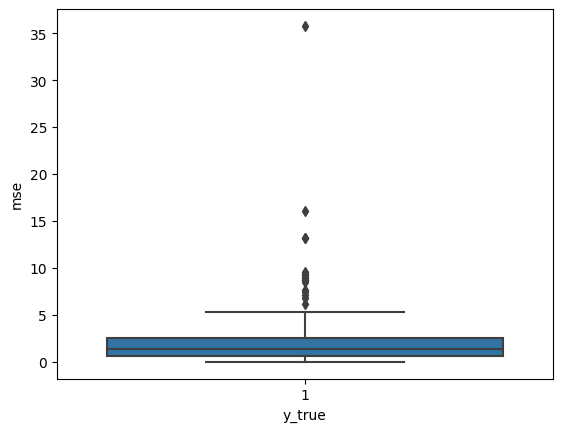

In [18]:
sns.boxplot(data=results[results.y_true==1], y="mse", x="y_true")

<Axes: xlabel='y_true', ylabel='mse'>

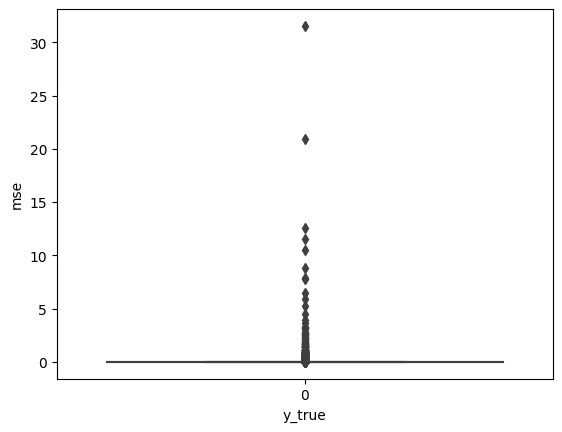

In [19]:
sns.boxplot(data=results[results.y_true==0], y="mse", x="y_true")

In [20]:
results[results.y_true==0].mse.quantile(0.5), results[results.y_true==1].mse.quantile(0.5), results[results.y_true==1].mse.min()

(0.007770371879725907, 1.4323434804949728, 0.003742128110678999)

In [21]:
results[results.y_true==0].mse.quantile(0.25), results[results.y_true==1].mse.quantile(0.25)

(0.004427338086624714, 0.5899946247569994)

The boxplot of the non-fraudulent class shows that the median mse value is 0.022 and some data points are outliers, i.e., they have been miscalssified as fraudulent (mse >>1) when they are not.

On the other hand, the median mse for fraudulent transactions is 4.8, with some outliers, i.e., fraudulent transacations miscalssified as non-fraudulent; the min mse on a fraudulent transaction is 0.0099<0.022.

In order to transform that back to a classification, we need to find a threshold of mse such that any transaction < threshold is non-fraudulent, otherwise fraudulent.

we want this threshold to give us the highest recall on the fraud class while keeping a decent precision, i.e., we want to predict all fraudulent transactions and we do not mind some of the non-fraudulent transactions getting misclassified.

For that, we will set this threshold to the mse median value of the fraudulent class: `results[results.y_true==1].mse.quantile(25)`.

In [22]:
results[results.y_true==1].mse.quantile(0.05)

0.012468501684925876

(0.0, 15.0)

<Figure size 800x600 with 0 Axes>

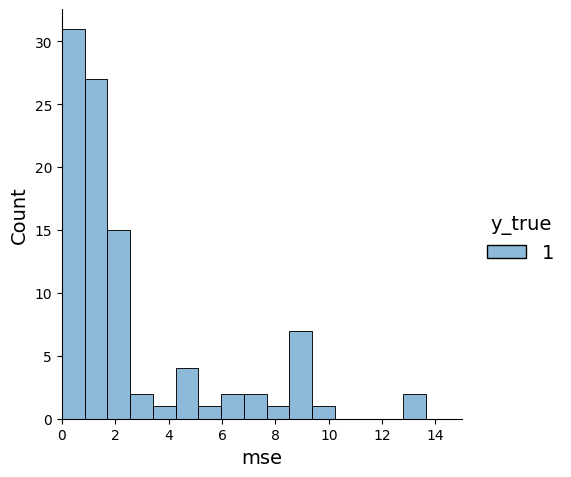

In [23]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.figure(figsize=(8, 6))

sns.displot(x=results[results.y_true==1].mse, hue=results[results.y_true==1].y_true)
plt.xlim(0,15)

(0.0, 1.0)

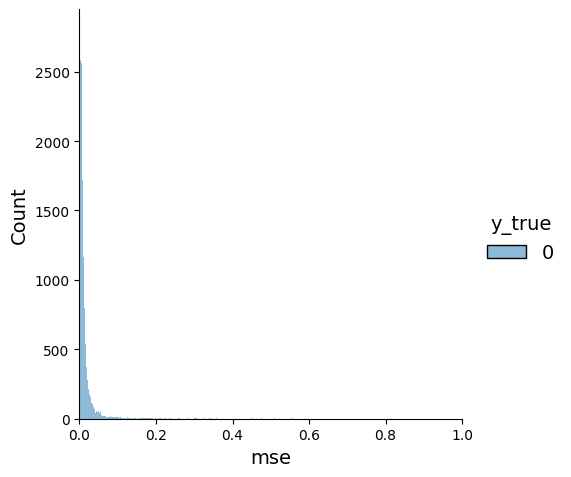

In [24]:
sns.displot(x=results[results.y_true==0].mse, hue=results[results.y_true==0].y_true)
plt.xlim(0,1)

In [48]:
# 100% sensitivity (no false negatives) and 100% specificity (no false positives)
from sklearn.metrics import confusion_matrix
thresholds = np.arange(0,2,0.01)
true_positive_rates = []
false_positive_rates = []
for thresh in thresholds:
  y_pred =results.mse.apply(lambda x: 0 if x<=thresh else 1)
  tn, fp, fn, tp = confusion_matrix(results['y_true'], y_pred).ravel()
  tpr = tp/(tp+fn) # true positive rate TPR = TP/(TP+FN) or recall/sensitivity
  true_positive_rates.append(tpr)
  fpr = fp/(fp+tn) # false positive rate, FPR = FP/(FP+TN) or specificity
  false_positive_rates.append(fpr)

(0.0, 0.025)

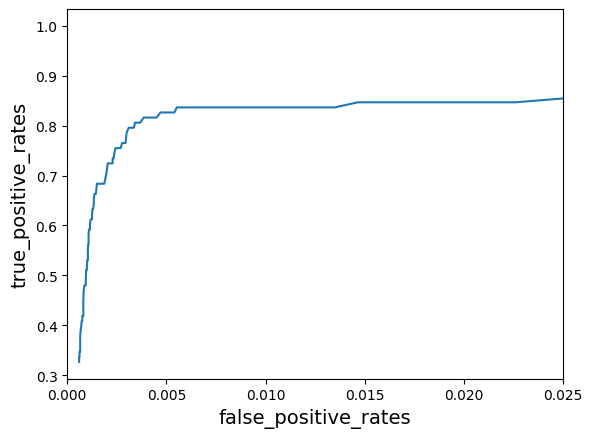

In [50]:
plt.plot(false_positive_rates, true_positive_rates)
plt.xlabel('false_positive_rates')
plt.ylabel('true_positive_rates')
plt.xlim(0, 0.025)
# plt.ylim(0, 1)

threshold is the value for which fpr = 0.00552195 and tpr=0.83673469 i.e., thresh = 0.31.


In [68]:
true_positive_rates = np.array(true_positive_rates)
false_positive_rates = np.array(false_positive_rates)
false_positive_rates[(false_positive_rates<=0.00552195) & (false_positive_rates>=0.0054)]
true_positive_rates[(false_positive_rates<=0.00552195) & (false_positive_rates>=0.0054)]
thresholds[(false_positive_rates<=0.00552195) & (false_positive_rates>=0.0054)]

array([0.31])

In [69]:
thresh = 0.31 #results[results.y_true==1].mse.quantile(0.15)
print("thresh", thresh)
results['y_pred'] = results.mse.apply(lambda x: 0 if x<=thresh else 1)

thresh 0.31


In [70]:
# let us compute the test accuracy
print(classification_report( results['y_true'], results['y_pred']))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.21      0.84      0.33        98

    accuracy                           0.99     56962
   macro avg       0.60      0.92      0.66     56962
weighted avg       1.00      0.99      1.00     56962



In [71]:
# Now if we use the precision recall curve, we will end up with the same result as above
from sklearn.metrics import recall_score, precision_score
thresholds = np.arange(0,2,0.01)
recalls = []
precisions = []
for thresh in thresholds:
  y_pred =results.mse.apply(lambda x: 0 if x<=thresh else 1)
  recall = recall_score(results['y_true'], y_pred)
  precision = precision_score(results['y_true'], y_pred)
  recalls.append(recall)
  precisions.append(precision)

Text(0, 0.5, 'precisions')

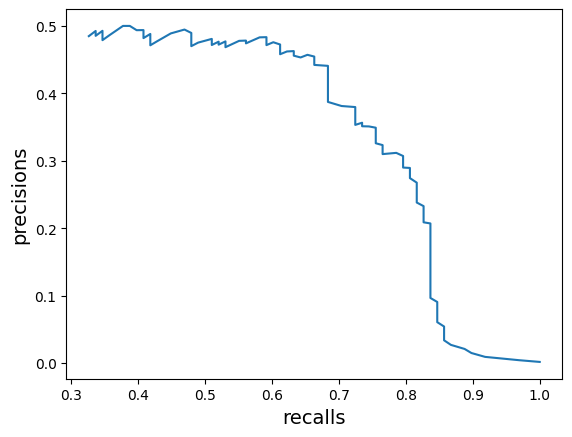

In [72]:
plt.plot(recalls, precisions)
plt.xlabel('recalls')
plt.ylabel('precisions')
# plt.xlim(0, 0.025)
# plt.ylim(0, 1)

In [73]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_majority_class_scaled = scaler.fit_transform(X_train_majority_class)
X_val_majority_class_scaled = scaler.transform(X_val_majority_class)
# in this case the last activation function is sigmoid because all the values are between 0 and 1

In [76]:
X_train_majority_class_scaled.min(), X_train_majority_class_scaled.max()

(0.0, 1.0000000000000002)

In [79]:
opt = optimizers.Adam(learning_rate=0.0001)
input_dim = X_train_majority_class.shape[1]
nn_model = Sequential()
nn_model.add(Dense(256, activation='relu'))
nn_model.add(Dense(512, activation='relu'))
nn_model.add(Dense(1024, activation='relu'))
nn_model.add(Dropout(0.1))
nn_model.add(Dense(2048, activation='relu'))
nn_model.add(Dense(1024, activation='relu'))
nn_model.add(Dropout(0.1))
nn_model.add(Dense(512, activation='relu'))
nn_model.add(Dense(256, activation='relu'))
nn_model.add(Dropout(0.1))
nn_model.add(Dense(input_dim, activation='sigmoid'))

nn_model.compile(loss='mse',
              optimizer=opt,
              metrics=[tf.keras.metrics.MeanSquaredError()])
#Train the model. Tune to validation set.
nn_model.fit(X_train_majority_class_scaled, X_train_majority_class_scaled,
          batch_size=30,
          epochs=5, validation_data=(X_val_majority_class_scaled, X_val_majority_class_scaled))

Epoch 1/5
5308/5308 [==============================] - 549s 103ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 1.1472e-04 - val_mean_squared_error: 1.1472e-04
Epoch 2/5
5308/5308 [==============================] - 454s 86ms/step - loss: 2.3742e-04 - mean_squared_error: 2.3742e-04 - val_loss: 7.3916e-05 - val_mean_squared_error: 7.3916e-05
Epoch 3/5
5308/5308 [==============================] - 455s 86ms/step - loss: 1.7996e-04 - mean_squared_error: 1.7996e-04 - val_loss: 7.6715e-05 - val_mean_squared_error: 7.6715e-05
Epoch 4/5
5308/5308 [==============================] - 456s 86ms/step - loss: 1.5681e-04 - mean_squared_error: 1.5681e-04 - val_loss: 6.2443e-05 - val_mean_squared_error: 6.2443e-05
Epoch 5/5
5308/5308 [==============================] - 470s 89ms/step - loss: 1.4213e-04 - mean_squared_error: 1.4213e-04 - val_loss: 4.5355e-05 - val_mean_squared_error: 4.5355e-05


In [80]:
mse = tf.keras.metrics.MeanSquaredError()
# Evaluate on the majority class (non-fraudulent); i will use the validation set:
print("on NON-Fraudulent class, MSE :",mse(nn_model.predict(X_val_majority_class_scaled), X_val_majority_class_scaled))
# Evaluate on the minority class (fraudulent):
X_train_minority_class_scaled = scaler.transform(X_train_minority_class)
reconstructed_samples = nn_model.predict(X_train_minority_class_scaled)
print("on Fraudulent class, MSE on scaled data:", mse(reconstructed_samples, X_train_minority_class_scaled))
reconstructed_samples_ = scaler.inverse_transform(reconstructed_samples)
print("on Fraudulent class, MSE on original data:", mse(reconstructed_samples_, X_train_minority_class))

2133/2133 [==============================] - 31s 14ms/step
on NON-Fraudulent class, MSE : tf.Tensor(4.5354525e-05, shape=(), dtype=float32)
13/13 [==============================] - 0s 13ms/step
on Fraudulent class, MSE on scaled data: tf.Tensor(7.311072e-05, shape=(), dtype=float32)
on Fraudulent class, MSE on original data: tf.Tensor(0.05717313, shape=(), dtype=float32)


In [81]:
# Evaluate on the test set; it contains instances from the minority class (fraudulent) and majority one (non-fraudulent):
X_test_scaled = scaler.transform(X_test)
reconstructed_test_samples = nn_model.predict(X_test_scaled)
error = ((reconstructed_test_samples-X_test_scaled)**2).mean(axis=1)

results = pd.DataFrame(data = {'y_true': y_test, 'mse':error})

1781/1781 [==============================] - 28s 16ms/step


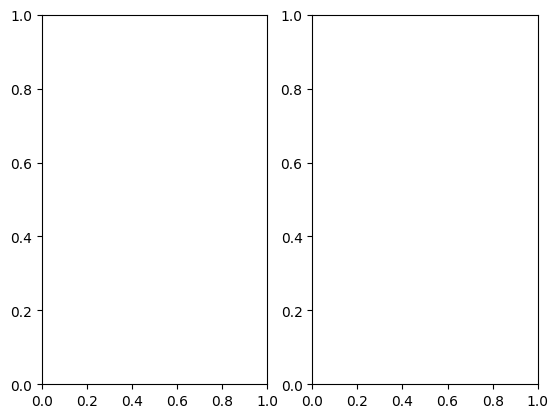

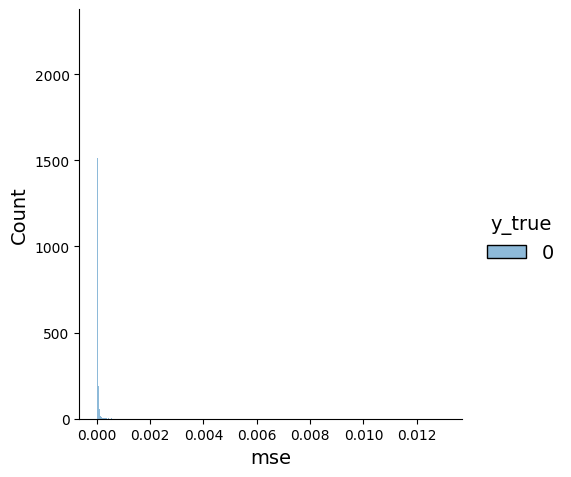

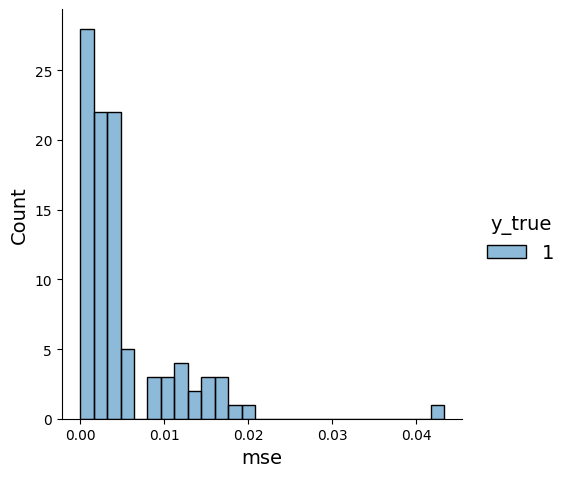

In [82]:
fig, ax = plt.subplots(nrows=1, ncols=2)
sns.displot(x=results[results.y_true==0].mse, hue=results[results.y_true==0].y_true, ax=ax[0])
# ax[0].set_xlim(0,1)
sns.displot(x=results[results.y_true==1].mse, hue=results[results.y_true==1].y_true, ax=ax[1])
# ax[1].set_xlim(0,1)

In [83]:
# Now if we use the precision recall curve, we will end up with the same result as above
from sklearn.metrics import recall_score, precision_score
thresholds = np.arange(0,0.02,0.001)
recalls = []
precisions = []
for thresh in thresholds:
  y_pred =results.mse.apply(lambda x: 0 if x<=thresh else 1)
  recall = recall_score(results['y_true'], y_pred)
  precision = precision_score(results['y_true'], y_pred)
  recalls.append(recall)
  precisions.append(precision)

Text(0, 0.5, 'precisions')

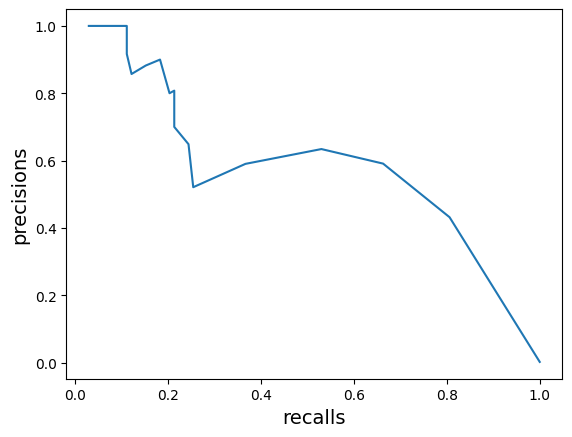

In [84]:
plt.plot(recalls, precisions)
plt.xlabel('recalls')
plt.ylabel('precisions')
# plt.xlim(0, 0.025)
# plt.ylim(0, 1)

In [89]:
recalls = np.array(recalls)
precisions = np.array(precisions)
recalls[(recalls>=0.8) &(recalls<=0.85)], precisions[(recalls>=0.8) &(recalls<=0.85)], thresholds[(recalls>=0.8) &(recalls<=0.85)]

(array([0.80612245]), array([0.43169399]), array([0.001]))

In [90]:
thresh = thresholds[(recalls>=0.8) &(recalls<=0.85)]
print("thresh", thresh)
results['y_pred'] = results.mse.apply(lambda x: 0 if x<=thresh else 1)

# let us compute the test accuracy
print(classification_report( results['y_true'], results['y_pred']))

thresh [0.001]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.43      0.81      0.56        98

    accuracy                           1.00     56962
   macro avg       0.72      0.90      0.78     56962
weighted avg       1.00      1.00      1.00     56962

